In [1]:
%load_ext autoreload
%autoreload 2

In [23]:
from google.cloud.bigquery import *

In [24]:
from utils.bqutils import connect, init_catalog

In [25]:
client = connect('bqresearch')

In [26]:
catalog = init_catalog()

### Population

In [36]:
population_per_year_40_49 = client.query(f'''
select age, year, population
from `coviddatail.staging.population_table`
where safe_cast(age as NUMERIC) between 40 and 49
and sex='total'
and county='total'
and area='total'
order by year
'''
).to_dataframe()

In [40]:
population_per_year_40_49.age = pd.to_numeric(population_per_year_40_49.age)
population_per_year_40_49.population = pd.to_numeric(population_per_year_40_49.population)
population_per_year_40_49.year = pd.to_numeric(population_per_year_40_49.year)
population_per_year_40_49 = population_per_year_40_49.groupby('year').sum().reset_index()

In [48]:
import numpy as np

In [53]:
population_per_year_40_49_extrapolted = population_per_year_40_49.set_index('year').reindex(np.arange(2000,2022))

In [55]:
population_per_year_40_49_extrapolted.population.values[-1] = \
    population_per_year_40_49_extrapolted.population.values[-3] + (
    population_per_year_40_49_extrapolted.population.values[-3] -
        population_per_year_40_49_extrapolted.population.values[-4])*2 

In [58]:
population_per_year_40_49_extrapolted = population_per_year_40_49_extrapolted.interpolate()

In [59]:
population_per_year_40_49_extrapolted

,age,population
year,,
2000,445.0,"750,953.0"
2001,445.0,"755,313.0"
2002,445.0,"757,016.0"
2003,445.0,"759,078.0"
2004,445.0,"763,585.0"
2005,445.0,"767,378.0"
2006,445.0,"773,516.0"
2007,445.0,"779,153.0"
2008,445.0,"814,259.0"


### Datagov: vaccinated_age_groups

In [107]:
vag_fr = client.query(f'''
select VaccinationDate as 
date, 
age_group, 
any_value(first_dose) first_dose,
any_value(second_dose) second_dose, 
any_value(third_dose) third_dose from
{catalog.coviddatail.staging.vaccinated_age_groups}
where age_group = '40-49'
group by 1, 2
order by VaccinationDate
''').to_dataframe()

In [108]:
vag_fr.sort_values(by='date')

,date,age_group,first_dose,second_dose,third_dose
0,2020-12-20,40-49,1868,0,0
1,2020-12-21,40-49,3790,0,0
2,2020-12-22,40-49,4537,0,0
3,2020-12-23,40-49,5041,0,0
4,2020-12-24,40-49,5216,0,0
...,...,...,...,...,...
376,2021-12-31,40-49,<15,<15,68
377,2022-01-01,40-49,<15,<15,26
378,2022-01-02,40-49,246,244,1302
379,2022-01-03,40-49,184,193,1039


In [8]:
import pandas as pd

In [109]:
vag_fr.date = pd.to_datetime(vag_fr.date)

In [123]:
vag_numeric = vag_fr.copy().sort_values(by='date').set_index('date')
vag_numeric['age_group_numeric'] = vag_numeric.age_group.str.split('-').apply(lambda x: x[0])
vag_numeric.iloc[:, 1:] = vag_numeric.iloc[:, 1:].replace('<15',0).replace('90+', '90').astype(int)

In [79]:
vag_grouped = vag_numeric.loc[:, ['date',  'first_dose', 'second_dose', 'third_dose']].groupby('date').max()

In [67]:
pd.options.display.float_format = '{:,}'.format

In [122]:
vag_numeric.first_dose

date
2020-12-20    1868
2020-12-21    3790
2020-12-22    4537
2020-12-23    5041
2020-12-24    5216
              ... 
2021-12-31     <15
2022-01-01     <15
2022-01-02     246
2022-01-03     184
2022-01-04     203
Name: first_dose, Length: 381, dtype: object

In [124]:
vag_cummulative = vag_numeric.copy().loc[:, ['first_dose', 'second_dose', 'third_dose']]
vag_cummulative = vag_cummulative.cumsum() / 1100000

In [127]:
vag_cummulative.dtypes

first_dose     float64
second_dose    float64
third_dose     float64
dtype: object

In [87]:
from bokeh_frame import charts

In [88]:
vag_grouped.date = pd.to_datetime(vag_grouped.date)

AttributeError: 'DataFrame' object has no attribute 'date'

### Bokeh chart 

In [128]:
vag_cummulative

,first_dose,second_dose,third_dose
date,,,
2020-12-20,0.001698181818181818,0.0,0.0
2020-12-21,0.005143636363636363,0.0,0.0
2020-12-22,0.009268181818181818,0.0,0.0
2020-12-23,0.01385090909090909,0.0,0.0
2020-12-24,0.01859272727272727,0.0,0.0
...,...,...,...
2021-12-31,0.9086909090909091,0.8448545454545454,0.6500681818181818
2022-01-01,0.9086909090909091,0.8448545454545454,0.6500918181818182
2022-01-02,0.9089145454545454,0.8450763636363636,0.6512754545454545


In [129]:
vag_cummulative.index

DatetimeIndex(['2020-12-20', '2020-12-21', '2020-12-22', '2020-12-23',
               '2020-12-24', '2020-12-25', '2020-12-26', '2020-12-27',
               '2020-12-28', '2020-12-29',
               ...
               '2021-12-26', '2021-12-27', '2021-12-28', '2021-12-29',
               '2021-12-30', '2021-12-31', '2022-01-01', '2022-01-02',
               '2022-01-03', '2022-01-04'],
              dtype='datetime64[ns]', name='date', length=381, freq=None)

In [130]:
vag_cummulative.index

DatetimeIndex(['2020-12-20', '2020-12-21', '2020-12-22', '2020-12-23',
               '2020-12-24', '2020-12-25', '2020-12-26', '2020-12-27',
               '2020-12-28', '2020-12-29',
               ...
               '2021-12-26', '2021-12-27', '2021-12-28', '2021-12-29',
               '2021-12-30', '2021-12-31', '2022-01-01', '2022-01-02',
               '2022-01-03', '2022-01-04'],
              dtype='datetime64[ns]', name='date', length=381, freq=None)

In [134]:
(
charts.Line('date', 'first_dose', vag_cummulative, color='blue').datetime().opts(width=1000)
    +
charts.Line('date', 'second_dose', vag_cummulative, color='red').datetime().opts(width=1000)
    +
charts.Line('date', 'third_dose', vag_cummulative, color='violet').datetime().opts(width=1000)
)

{'first_dose': '@first_dose', 'second_dose': '@second_dose', 'third_dose': '@third_dose', 'date': '@date{%F}'}


Figure(id='5456', ...)

In [ ]:
vag_grouped.to_csv('vax_per_day_40_49.csv')

In [15]:
%matplotlib inline

<AxesSubplot:xlabel='date'>

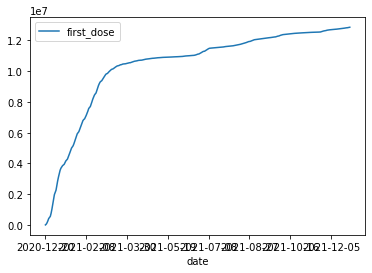

In [16]:
fr.plot(kind='line', x='date', y='first_dose')

In [17]:
fr.shape

(374, 4)

<AxesSubplot:xlabel='date'>

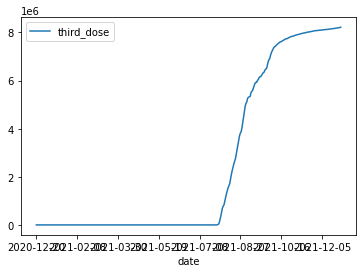

In [18]:
fr.plot(kind='line', x='date', y='third_dose')

In [19]:
fr.loc[:, ['first_dose', 'second_dose', 'third_dose']].max()

first_dose     12839795
second_dose    11662185
third_dose      8217390
dtype: int64

### Dashboard

In [177]:
print(f'''
select batch_date, 
Day_Date as date, 
{catalog.coviddatail.staging.vaccinated.vaccinated} as first_dose,
{catalog.coviddatail.staging.vaccinated.vaccinated_seconde_dose} as second_dose,
{catalog.coviddatail.staging.vaccinated.vaccinated_third_dose} as third_dose,
from
coviddatail.staging.vaccinated
where batch_date=(select max(batch_date) from {catalog.coviddatail.staging.vaccinated})
order by Day_Date
''')


select batch_date, 
Day_Date as date, 
vaccinated as first_dose,
vaccinated_seconde_dose as second_dose,
vaccinated_third_dose as third_dose,
from
coviddatail.staging.vaccinated
where batch_date=(select max(batch_date) from coviddatail.staging.vaccinated)
order by Day_Date



In [186]:
dash_fr = client.query(f'''
select batch_date, 
Day_Date as date, 
vaccinated as first_dose2,
vaccinated_seconde_dose as second_dose,
vaccinated_third_dose as third_dose,
from
staging.vaccinated
where batch_date=(select max(batch_date) from {catalog.coviddatail.staging.vaccinated})
order by Day_Date
''')

In [187]:
dash_fr.to_dataframe()

,batch_date,date,first_dose2,second_dose,third_dose
0,2021-12-31,2021-07-24T00:00:00.000Z,"{'Day_Date': '2021-07-24T00:00:00.000Z', 'vacc...",1417,6
1,2021-12-31,2021-07-25T00:00:00.000Z,"{'Day_Date': '2021-07-25T00:00:00.000Z', 'vacc...",15435,222
2,2021-12-31,2021-07-26T00:00:00.000Z,"{'Day_Date': '2021-07-26T00:00:00.000Z', 'vacc...",13405,320
3,2021-12-31,2021-07-27T00:00:00.000Z,"{'Day_Date': '2021-07-27T00:00:00.000Z', 'vacc...",13444,410
4,2021-12-31,2021-07-28T00:00:00.000Z,"{'Day_Date': '2021-07-28T00:00:00.000Z', 'vacc...",12228,459
...,...,...,...,...,...
155,2021-12-31,2021-12-26T00:00:00.000Z,"{'Day_Date': '2021-12-26T00:00:00.000Z', 'vacc...",8892,8116
156,2021-12-31,2021-12-27T00:00:00.000Z,"{'Day_Date': '2021-12-27T00:00:00.000Z', 'vacc...",7102,8035
157,2021-12-31,2021-12-28T00:00:00.000Z,"{'Day_Date': '2021-12-28T00:00:00.000Z', 'vacc...",7413,9466
158,2021-12-31,2021-12-29T00:00:00.000Z,"{'Day_Date': '2021-12-29T00:00:00.000Z', 'vacc...",5923,8157


In [135]:
dash_fr.date = pd.to_datetime(dash_fr.date)
dash_fr.loc[:, ['first_dose', 'second_dose', 'third_dose']]

,first_dose,second_dose,third_dose
0,"{'Day_Date': '2021-07-24T00:00:00.000Z', 'vacc...",1417,6
1,"{'Day_Date': '2021-07-25T00:00:00.000Z', 'vacc...",15435,222
2,"{'Day_Date': '2021-07-26T00:00:00.000Z', 'vacc...",13405,320
3,"{'Day_Date': '2021-07-27T00:00:00.000Z', 'vacc...",13444,410
4,"{'Day_Date': '2021-07-28T00:00:00.000Z', 'vacc...",12228,459
...,...,...,...
155,"{'Day_Date': '2021-12-26T00:00:00.000Z', 'vacc...",8892,8116
156,"{'Day_Date': '2021-12-27T00:00:00.000Z', 'vacc...",7102,8035
157,"{'Day_Date': '2021-12-28T00:00:00.000Z', 'vacc...",7413,9466
158,"{'Day_Date': '2021-12-29T00:00:00.000Z', 'vacc...",5923,8157


In [21]:
fr2.loc[:, ['first_dose', 'second_dose', 'third_dose']].max()*2

first_dose     65580816558081
second_dose    59166765916676
third_dose       964864964864
dtype: object

In [22]:
fr2.date = pd.to_datetime(fr2.date)

In [23]:
fr2.iloc[:, 1:] = fr2.iloc[:, 1:].astype(int)

<AxesSubplot:xlabel='date'>

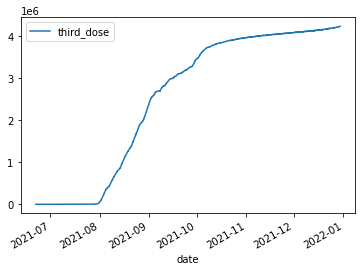

In [24]:
fr2.plot(kind='line', x='date', y='third_dose')

In [29]:
fr.date = pd.to_datetime(fr.date)

In [31]:
fr2.date = fr2.date.dt.date

In [43]:
joint = fr2.set_index('date').join(fr.set_index('date'), lsuffix='_l', rsuffix='_r')

In [37]:
fr.set_index('date')

,first_dose,second_dose,third_dose
date,,,
2020-12-20,14752,0,0
2020-12-21,64565,0,0
2020-12-22,153819,0,0
2020-12-23,279561,0,0
2020-12-24,426333,0,0
...,...,...,...
2021-12-24,12804154,11636292,8189859
2021-12-25,12807460,11638822,8191841
2021-12-26,12818106,11647701,8199948


In [50]:
import numpy as np

In [57]:
np.polyfit(joint.second_dose_l.values[0:100], joint.second_dose_r.values[0:100], 1)

array([1.92026004e+00, 4.09905064e+05])

In [59]:
charts.Dots(joint.second_dose_l, joint.second_dose_r).with_identity()

{'X': '@X', 'Y': '@Y'}


Figure(id='1397', ...)

In [56]:
joint

,first_dose_l,second_dose_l,third_dose_l,first_dose_r,second_dose_r,third_dose_r
date,,,,,,
2021-06-22,5520990,5167077,0,11039693.0,10332325.0,0.0
2021-06-23,5531571,5168241,0,11060851.0,10334637.0,0.0
2021-06-24,5543452,5169582,0,11084607.0,10337313.0,0.0
2021-06-25,5550417,5170385,0,11098517.0,10338889.0,0.0
2021-06-26,5552616,5170512,0,11102879.0,10339108.0,0.0
...,...,...,...,...,...,...
2021-12-28,6535688,5901291,4217518,12839795.0,11662185.0,8217390.0
2021-12-28,6537340,5902956,4219217,12839795.0,11662185.0,8217390.0
2021-12-29,6547908,5909606,4227734,NaN,NaN,NaN


Number of ppl w. third dose: 4179311
How many ppl are there? above, say, 10

In [294]:
population_per_year = client.query(f'''
select year, age, population
from `coviddatail.staging.population_table`
where age <> 'total' and safe_cast(age AS NUMERIC) > 10
and sex='total'
and county='total'
and area='total'
order by year
'''
).to_dataframe()

In [295]:
population_per_year = population_per_year.astype(float)

In [248]:
population_per_year_above_ten = population_per_year.loc[population_per_year.age.astype(float) > 10, :]

In [296]:
pop2019 = population_per_year.loc[population_per_year.year == 2019,:]

In [303]:
pop2018 = population_per_year.loc[population_per_year.year == 2018,:]

In [301]:
total_pop_2019_above_10 = pop2019.sort_values(by='age').sum().population

In [304]:
total_pop_2018_above_10 = pop2018.sort_values(by='age').sum().population

In [306]:
total_pop_2019_above_10 + 2*(total_pop_2019_above_10 - total_pop_2018_above_10)

7476155.0

In [282]:
population_per_year.groupby('year').sum()

,age,population
year,,
2000,3781,4140391
2001,3750,4022540
2002,3806,4440519
2003,3813,4501437
2004,3936,4828680
2005,3720,4235584
2006,3722,4329209
2007,3575,3742370
2008,2984,3003347


In [274]:
_.population.sum()

'1330831161881092801101791070761033928410483057815407886278859809377829477166760377542976337739377469575062744257329665728652597084264367509694319537652358203765338622386824010240277364963357230907270452365222816201501953317817166091420412040913833166'

In [258]:

population_per_year_above_ten.age.drop_duplicates()

3         11
4         12
5         13
6         14
7         15
        ... 
1454    54.0
1545    55.0
1637    85.0
1727    84.0
1817    51.0
Name: age, Length: 140, dtype: object

In [259]:
_.shape

(140,)

In [307]:
4179311 / 7476155

0.5590187736878115